# Clustering Milan's Neighborhoods

Milan is one of the best city to live in Italy. Modern, multicultural, rich of art, museums, restaurants and with the biggest subway network in the country . It's definitely a Metropoli that can be easily compared to other big cities like Paris or New York. I am an Italian and like any Italian I love food, art, shopping and soccer of course. I will extract venues information of those categories using Foursquare API and I will cluster the neighborhoods of Milan in order to find similarities between them. If i want to eat sushi and visit a museum, which neighborhood should i visit? I am looking for an apartment, close to transportation station and to an italian restaurant, which neighborhood should i consider? that's the kind of question i'll try to answer in this report.

Importing useful libraries

In [2]:
import pandas as pd
import numpy as np
import re
import requests
import folium
from folium import plugins
from sklearn.cluster import KMeans 
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

Define new class City who will holds Milan's info about zones (name and geojson for plotting) and suburbs/neighborhoods

In [3]:
class City:
    def __init__ (self, name, geoJson, centrion):
        self.name = name
        self.geoJson = geoJson
        self.centrion = centrion
        self.zones = []
        self.suburbs = []
        
    def addSuburb (self, name, coords):
        self.suburbs.append({'name': name,
                             'coords': coords})
        
    def addZone (self, name, geoJson):
        self.zones.append({'name': name,
                           'geoJson': geoJson})

#### Retrieve Milan's info using Nominatim
Retrieve Milan city information using Openstreetmap's Nominatim API and plot the geojson on a map using Folium.

In [4]:
url = 'https://nominatim.openstreetmap.org/search?city={}&country={}&format={}&polygon_geojson=1'.format('milan','italy','json')
results = requests.get(url).json()

In [5]:
milanArea = City( 'Milan', results[0]['geojson'], [ results[0]['lat'], results[0]['lon'] ] )
milanArea.addSuburb('Milan Central zone', [ results[0]['lat'], results[0]['lon'] ] )
# create map of Milan using latitude and longitude values
milan = folium.Map(location=milanArea.centrion, 
                   zoom_start=12,
                   tiles = 'CartoDb dark_matter')

style_function = lambda x: {'fillColor': '#FFFFff',
                            'color': '#FFFFFF'}

folium.GeoJson(
    milanArea.geoJson,
    name='Milan geojson',
    style_function=style_function
).add_to(milan)

folium.CircleMarker(
        milanArea.centrion,
        radius=5,
        popup='Milan, Lombardy, Italy',
        color='white',
        fill=True,
        fill_color='#F4F6F7',
        fill_opacity=0.7,
        parse_html=False).add_to(milan)
  
milan

Always using Openstreetmap's Nominatim API we can retrieve the different administrative zones.

In [6]:
url = 'https://nominatim.openstreetmap.org/details?osmtype=R&osmid={}&class=boundary&format={}&hierarchy=1&group_hierarchy=1&addressdetails=1'.format(results[0]['osm_id'],'json')     
# make the GET request
details = requests.get(url).json()

In [7]:
for admin in details['hierarchy']['administrative']:
    url = 'https://nominatim.openstreetmap.org/details?osmtype=R&osmid={}&class=boundary&format={}&hierarchy=1&group_hierarchy=1&addressdetails=1&polygon_geojson=1'.format(admin['osm_id'],'json')     
    admin_det = requests.get(url).json()
    geojson = admin_det['geometry']
    folium.GeoJson(
        geojson,
        name='{} geojson'.format(admin_det['localname']),
        style_function=style_function
    ).add_to(milan)
    milanArea.addZone(admin_det['localname'], geojson)

In [8]:
for suburb in details['hierarchy']['suburb']:
    if suburb['osm_type'] == 'N':
        url = 'https://nominatim.openstreetmap.org/details?osmtype=N&osmid={}&class=place&format={}&hierarchy=1&group_hierarchy=1&addressdetails=1&polygon_geojson=1'.format(suburb['osm_id'],'json')     
        sub_det = requests.get(url).json()
        folium.CircleMarker([sub_det['centroid']['coordinates'][1], sub_det['centroid']['coordinates'][0]],
                            radius=5,
                            popup='{}, Milan, Lombardy, Italy'.format(sub_det['localname']),
                            color='white',
                            fill=True,
                            fill_color='#F4F6F7',
                            fill_opacity=0.7,
                            parse_html=False).add_to(milan)
        milanArea.addSuburb(sub_det['localname'], [sub_det['centroid']['coordinates'][1], sub_det['centroid']['coordinates'][0]])

In [9]:
folium.LayerControl().add_to(milan)

In [10]:
milan

#### Retrieve venues using Foursquare API

We will retrieve venues of type : food, arts, outdoor, transport and shop.  
In our dataframe will have both the information about the specific venue category plus the more generic one.  
For example :
- a thai restaurant will have venue category equal to thai restaurant and main category equal to food
- a bar will have venue category equal to bar and main category equal to food
- a shopping mall will have venue category equal to mall and main category equal to shop  

This will allow us to test 2 different kind of clustering :
- based on main category
- based on vanue category

In [25]:
CLIENT_ID = 'KHPKNWLUOM2M2GOBRPPE355RX3IS2HEWCWJTP0HYY4BOYG2L'
CLIENT_SECRET = '5PJK30XKFHXCYJWVJ1ZJVQFDMWFZDKLIX5JRKUCYKLJAVAZS'
VERSION = '20200301' # Foursquare API version

print('Credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Credentails:
CLIENT_ID: KHPKNWLUOM2M2GOBRPPE355RX3IS2HEWCWJTP0HYY4BOYG2L
CLIENT_SECRET:5PJK30XKFHXCYJWVJ1ZJVQFDMWFZDKLIX5JRKUCYKLJAVAZS


In [12]:
def getNearbyVenues(suburbs, radius=500, LIMIT=500):
    
    venues_list=[]
    for suburb in suburbs:
            
        # create the API request URL to retrieve all veniew of category food from foursquare 
        for categ in [('food','4d4b7105d754a06374d81259'),
                      ('arts','4d4b7104d754a06370d81259'),
                      ('outdoor','4d4b7105d754a06377d81259'),
                      ('shop','4d4b7105d754a06378d81259'),
                      ('transport','4d4b7105d754a06379d81259')]:
            
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
                CLIENT_ID, CLIENT_SECRET, VERSION, suburb['coords'][0], suburb['coords'][1], radius, LIMIT, categ[1])

            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']

            # return only relevant information for each nearby venue
            venues_list.append([(
                suburb['name'], suburb['coords'][0], suburb['coords'][1], 
                v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name'], categ[0]) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Suburb', 
                          'Suburb Latitude', 
                          'Suburb Longitude', 
                          'Venue', 
                          'Venue Latitude', 
                          'Venue Longitude', 
                          'Venue Category',
                          'Venue Main Category']
    
    return(nearby_venues)

In [13]:
milan_venues = getNearbyVenues(milanArea.suburbs)

save into csv file

In [224]:
#milan_venues.to_csv('venues_in_milan.csv', index=False)

explore data

In [74]:
milan_venues[ milan_venues['Suburb'] == 'Affori'].head(20)

,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Main Category
268,Affori,45.517,9.16965,Osteria del Biliardo,45.514812,9.169422,Italian Restaurant,food
269,Affori,45.517,9.16965,Pizzeria Astesani,45.516140,9.172112,Pizza Place,food
270,Affori,45.517,9.16965,Su Barrile,45.514659,9.173045,Pizza Place,food
271,Affori,45.517,9.16965,Good Morning Caffè,45.517397,9.171455,Café,food
272,Affori,45.517,9.16965,Chicken & Chicken,45.513721,9.173872,Fried Chicken Joint,food
273,Affori,45.517,9.16965,Ristorante Pizzeria La Pianta,45.517067,9.171549,Italian Restaurant,food
274,Affori,45.517,9.16965,Asian Mood,45.518560,9.170494,Japanese Restaurant,food
275,Affori,45.517,9.16965,Bar Cooperativa Sempre Uniti,45.514818,9.169263,Café,food
276,Affori,45.517,9.16965,Bar De L 'Oeuc,45.515875,9.172474,Café,food
277,Affori,45.517,9.16965,Ristorante Affori,45.519366,9.169980,Italian Restaurant,food


In [78]:
from sklearn.utils import shuffle
df_temp = shuffle(milan_venues)
df_temp.head(15)

,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Main Category
2784,Porta Ticinese,45.4527,9.18023,Mudra Vegamore,45.453253,9.179246,Vegetarian / Vegan Restaurant,food
2267,Porta Lodovica,45.4519,9.18769,Quei Due,45.450592,9.182077,Restaurant,food
2089,Porta Garibaldi,45.4807,9.18689,Under Armour,45.483258,9.189143,Clothing Store,shop
2473,Porta Nuova,45.4785,9.19434,Assunta Madre,45.480612,9.199470,Seafood Restaurant,food
2021,Porta Garibaldi,45.4807,9.18689,La BisBistecca,45.480164,9.193181,Steakhouse,food
3430,Precotto,45.5127,9.225,Pan per Focaccia Caffè,45.512332,9.224396,Bakery,food
1066,Corvetto,45.4377,9.22471,Farmacia Corvetto,45.440533,9.224196,Pharmacy,shop
930,Conchetta,45.4455,9.17683,100 Montaditos,45.446989,9.176994,Sandwich Place,food
3837,Segnano,45.5072,9.20705,Telerie Mercato,45.508038,9.202319,Baby Store,shop
434,Boldinasco,45.4926,9.13855,Il Pavone,45.493922,9.143421,Italian Restaurant,food


In [15]:
milan_venues.shape

(4094, 8)

#### Data analysis

##### Venue category frequency

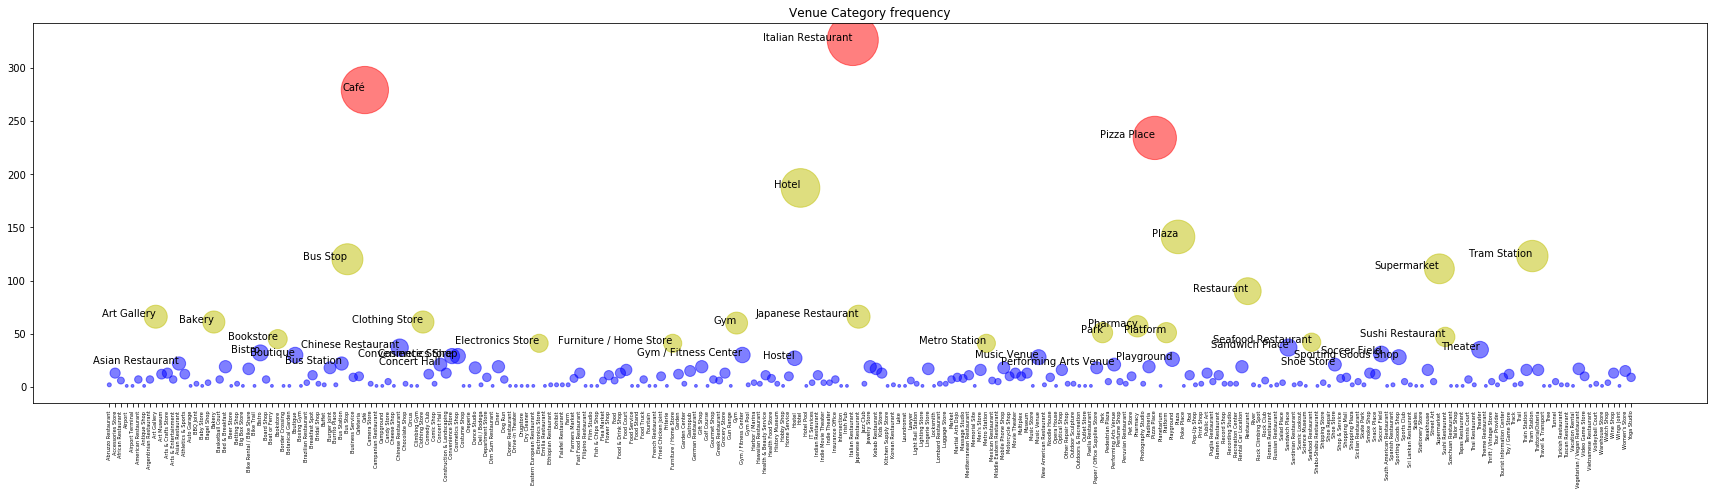

In [27]:
unique, counts = np.unique(milan_venues['Venue Category'], return_counts=True)
col = np.where(counts<40,'b',np.where(counts<200,'y','r'))
area = counts*8
plt.figure(figsize=(30, 7))
plt.scatter(x=unique,
            y=counts,
            c=col,
            s=area,
            alpha=0.5)
plt.xticks(rotation=90)
plt.title('Venue Category frequency')
[plt.text(x,y,x,horizontalalignment='right')  for x,y in zip(unique,counts) if y>20]
plt.tick_params(axis='x', which='major', labelsize=5)
plt.show()

In [18]:
print('There are {} uniques categories.'.format(len(milan_venues['Venue Category'].unique())))

There are 263 uniques categories.


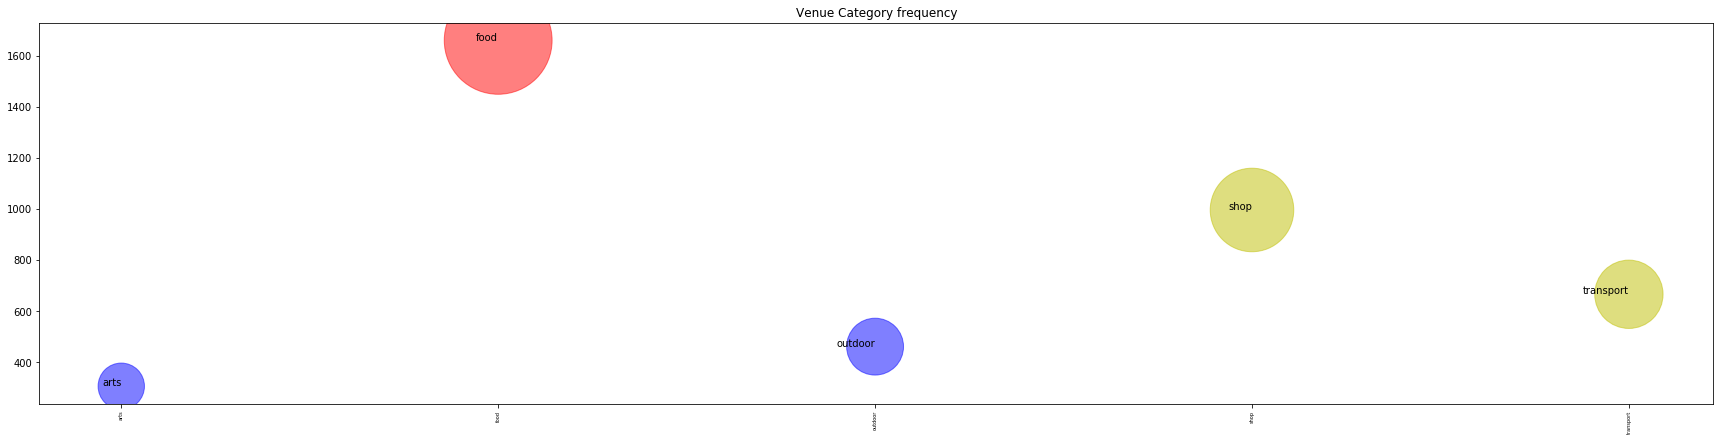

In [21]:
unique, counts = np.unique(milan_venues['Venue Main Category'], return_counts=True)
col = np.where(counts<500,'b',np.where(counts<1500,'y','r'))
area = counts*7
plt.figure(figsize=(30, 7))
plt.scatter(x=unique,
            y=counts,
            c=col,
            s=area,
            alpha=0.5)
plt.xticks(rotation=90)
plt.title('Venue Category frequency')
[plt.text(x,y,x,horizontalalignment='right')  for x,y in zip(unique,counts) if y>20]
plt.tick_params(axis='x', which='major', labelsize=5)
plt.show()

##### Frequency by venue category and by neighborhood

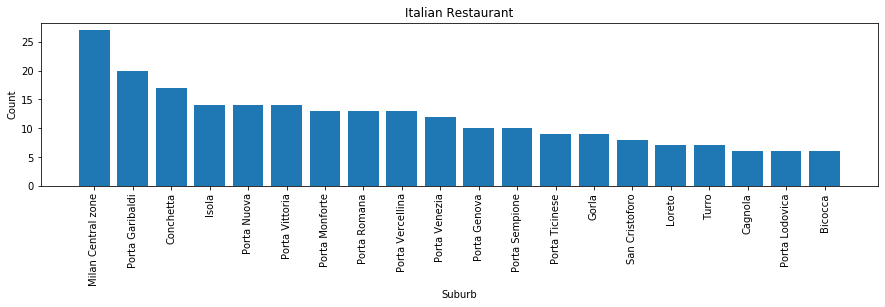

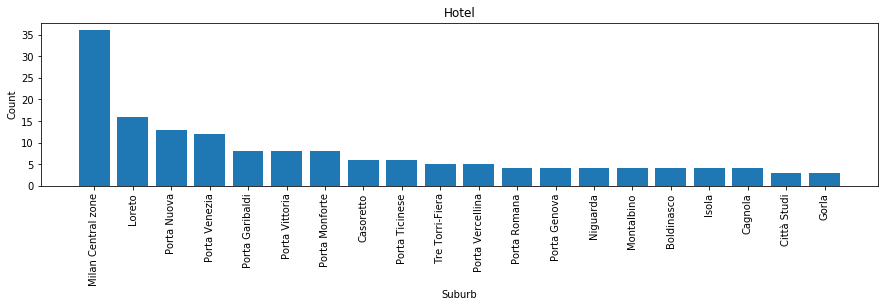

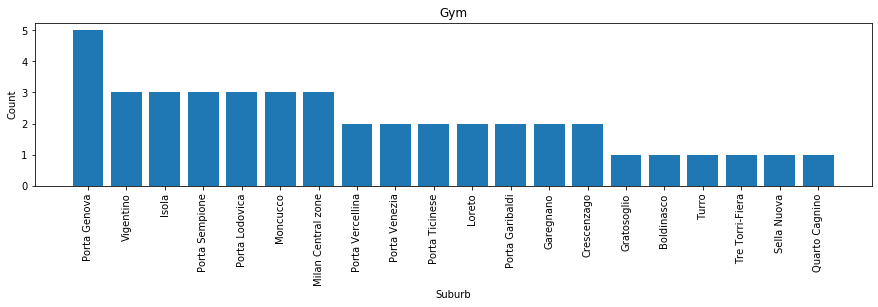

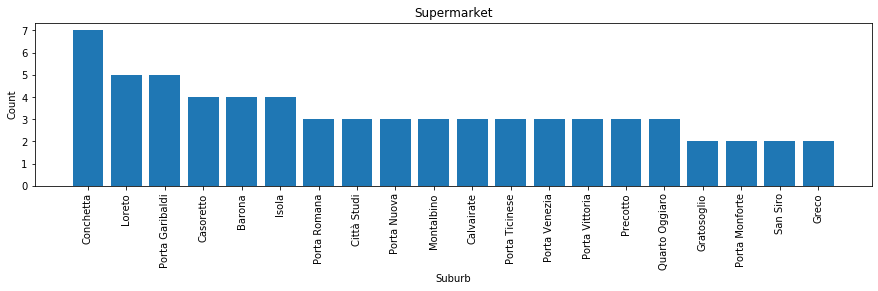

In [28]:
for category in ['Italian Restaurant', 'Hotel', 'Gym', 'Supermarket']:
    itaRest = milan_venues[ milan_venues['Venue Category'] == category ].groupby('Suburb',as_index=False).count()
    top20 = itaRest.sort_values('Venue Category', ascending=False).reset_index(drop=True).head(20)
    plt.figure(figsize=(15, 3))
    plt.title(category)
    plt.bar(x=top20['Suburb'], 
            height=top20['Venue Category'])
    plt.xticks(rotation=90)
    plt.xlabel('Suburb')
    plt.ylabel('Count')
    plt.show()

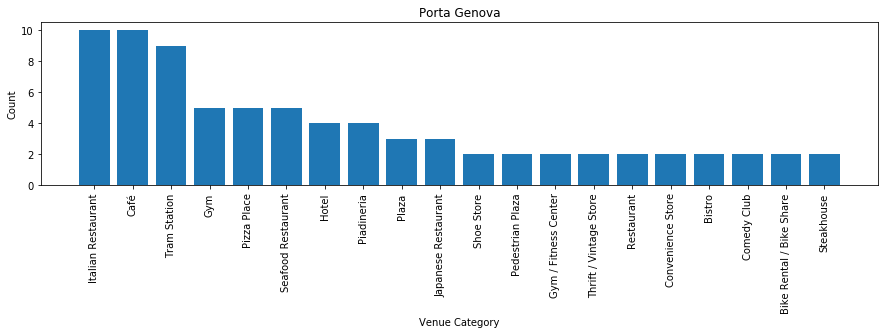

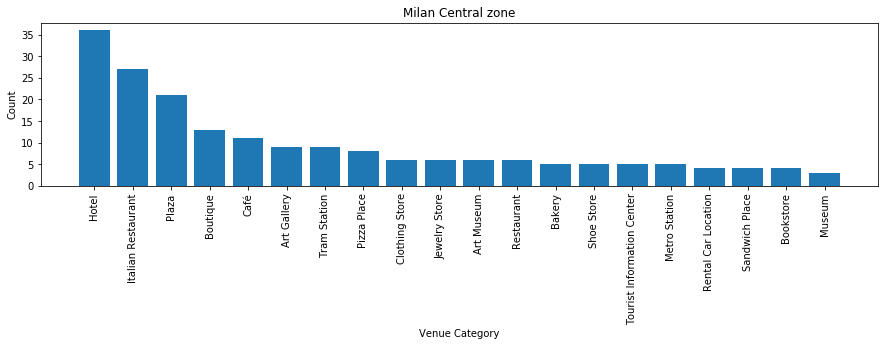

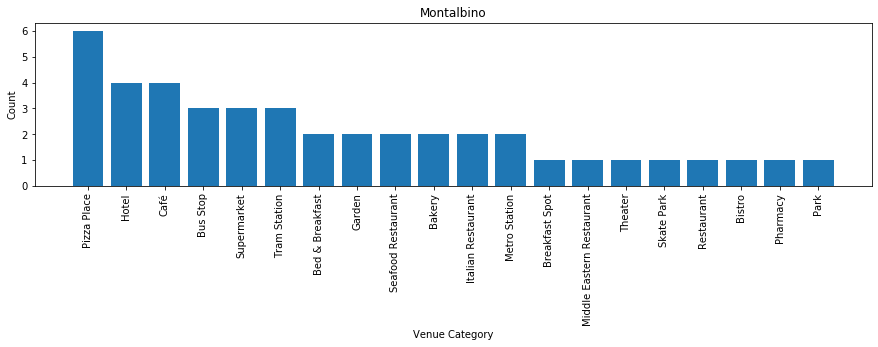

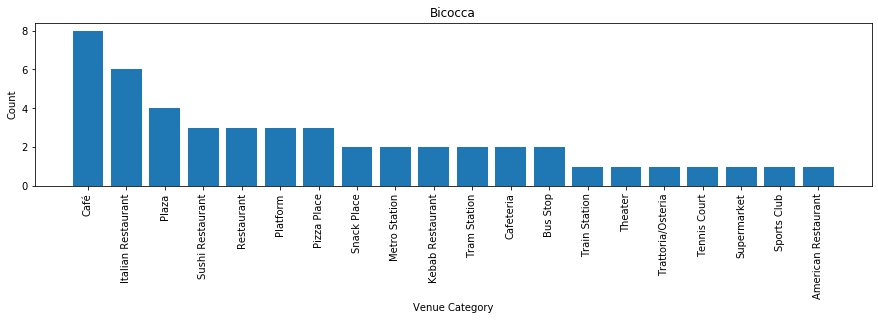

In [29]:
for subs in ['Porta Genova','Milan Central zone','Montalbino','Bicocca']:
    itaRest = milan_venues[ milan_venues['Suburb'] == subs ].groupby('Venue Category',as_index=False).count()
    top20 = itaRest.sort_values('Venue', ascending=False).reset_index(drop=True).head(20)
    plt.figure(figsize=(15, 3))
    plt.title(subs)
    plt.bar(x=top20['Venue Category'], 
            height=top20['Venue'])
    plt.xticks(rotation=90)
    plt.xlabel('Venue Category')
    plt.ylabel('Count')
    plt.show()

### Clustering on Venue Category

In [30]:
# one hot encoding
milan_encoded = pd.get_dummies(milan_venues[['Venue Category']], prefix="", prefix_sep="")
# add suburb column back to dataframe
milan_encoded['Suburb'] = milan_venues['Suburb'] 
# move suburb column to the first column
fixed_columns = [milan_encoded.columns[-1]] + list(milan_encoded.columns[:-1])
milan_encoded = milan_encoded[fixed_columns]
# group by suburb and calculate the mean
milan_encoded_grouped = milan_encoded.groupby('Suburb').mean().reset_index()
milan_encoded_grouped

,Suburb,Abruzzo Restaurant,Accessories Store,African Restaurant,Airport,Airport Terminal,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,...,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Watch Shop,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Affori,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
1,Baggio,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
2,Barona,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
3,Bicocca,0.000000,0.0,0.0,0.0,0.0,0.017241,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.017241,0.0
4,Boldinasco,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.090909,...,0.0,0.0,0.0,0.030303,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,Trenno,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
72,Turro,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.023810,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
73,Vialba,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
74,Vigentino,0.022222,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0


find best K

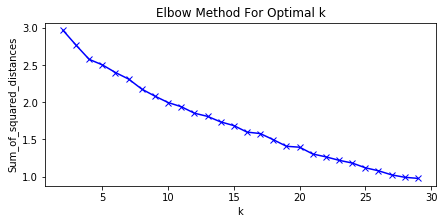

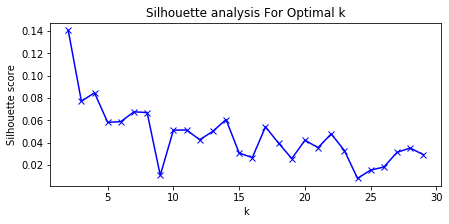

In [31]:
from sklearn.metrics import silhouette_score

sil_scores = []
Sum_of_squared_distances = []
K = range(2,30)
df_clustering = milan_encoded_grouped.drop('Suburb', 1)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_clustering)
    Sum_of_squared_distances.append(km.inertia_)
    sil_scores.append(silhouette_score(df_clustering, km.labels_, metric='euclidean'))

plt.figure(figsize=(7, 3))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

plt.figure(figsize=(7, 3))
plt.plot(K, sil_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k')
plt.show()

3 or 9 is the best k  
silhouette score is very low, that would probably mean that clustering on all the venue categories it may not be the best option.  
we can chose a specific category of venue and cluster on it.  
Let s first visualize the cluster and let s chose k=9.  

### Clustering on Venue Main Category

In [32]:
# one hot encoding
milan_encoded_vmc = pd.get_dummies(milan_venues[['Venue Main Category']], prefix="", prefix_sep="")
# add suburb column back to dataframe
milan_encoded_vmc['Suburb'] = milan_venues['Suburb'] 
# move suburb column to the first column
fixed_columns = [milan_encoded_vmc.columns[-1]] + list(milan_encoded_vmc.columns[:-1])
milan_encoded_vmc = milan_encoded_vmc[fixed_columns]
# group by suburb and calculate the mean
milan_encoded_grouped_vmc = milan_encoded_vmc.groupby('Suburb').mean().reset_index()
milan_encoded_grouped_vmc

,Suburb,arts,food,outdoor,shop,transport
0,Affori,0.250000,0.357143,0.107143,0.214286,0.071429
1,Baggio,0.058824,0.235294,0.117647,0.529412,0.058824
2,Barona,0.076923,0.410256,0.102564,0.282051,0.128205
3,Bicocca,0.017241,0.655172,0.103448,0.051724,0.172414
4,Boldinasco,0.151515,0.363636,0.151515,0.090909,0.242424
...,...,...,...,...,...,...
71,Trenno,0.062500,0.312500,0.375000,0.250000,0.000000
72,Turro,0.214286,0.404762,0.166667,0.071429,0.142857
73,Vialba,0.000000,0.222222,0.333333,0.222222,0.222222
74,Vigentino,0.066667,0.488889,0.111111,0.177778,0.155556


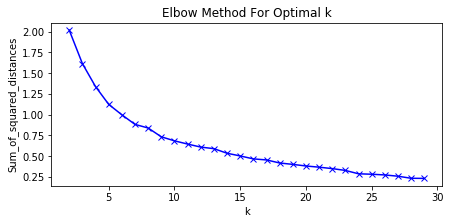

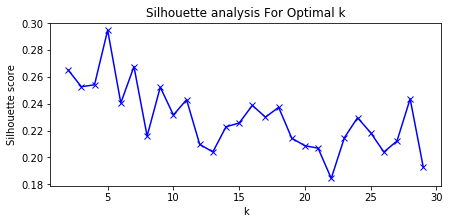

In [33]:
from sklearn.metrics import silhouette_score

sil_scores_vmc = []
Sum_of_squared_distances_vmc = []
K = range(2,30)
df_clustering_vmc = milan_encoded_grouped_vmc.drop('Suburb', 1)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_clustering_vmc)
    Sum_of_squared_distances_vmc.append(km.inertia_)
    sil_scores_vmc.append(silhouette_score(df_clustering_vmc, km.labels_, metric='euclidean'))

plt.figure(figsize=(7, 3))
plt.plot(K, Sum_of_squared_distances_vmc, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

plt.figure(figsize=(7, 3))
plt.plot(K, sil_scores_vmc, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k')
plt.show()

in this case 5 is the best k. 
silhouette score is increasing but it is still quite low.    

### Final Clustering : Venue Category

In [36]:
def getLatLon(subs):
    for el in milanArea.suburbs:
        if el['name']==subs:
            return el['coords']
    
# set number of clusters
kclusters = 9
milan_cluster9 = milan_encoded_grouped.drop('Suburb', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(milan_cluster9)
# cluster labels generated for each row in the dataframe
milan_cluster9.insert(0, 'Cluster Labels', kmeans.labels_)
milan_cluster9.insert(0, 'Suburb', milan_encoded_grouped['Suburb'])
milan_cluster9['Latitude'] = milan_cluster9.apply(lambda row: getLatLon(row.Suburb)[0] , axis=1)
milan_cluster9['Longitude'] = milan_cluster9.apply(lambda row: getLatLon(row.Suburb)[1] , axis=1)
milan_cluster9.head(10)

,Suburb,Cluster Labels,Abruzzo Restaurant,Accessories Store,African Restaurant,Airport,Airport Terminal,American Restaurant,Antique Shop,Argentinian Restaurant,...,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Watch Shop,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Latitude,Longitude
0,Affori,1,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,45.517,9.16965
1,Baggio,1,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,45.4614,9.08984
2,Barona,2,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,45.4388,9.15467
3,Bicocca,5,0.0,0.000000,0.0,0.0,0.0,0.017241,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.017241,0.0,45.5149,9.21114
4,Boldinasco,1,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.030303,0.0,0.0,0.0,0.0,0.000000,0.0,45.4926,9.13855
5,Bovisa,5,0.0,0.015625,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,45.5028,9.16126
6,Bovisasca,7,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,45.5158,9.15378
7,Bruzzano,1,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,45.5274,9.17329
8,Cagnola,1,0.0,0.012500,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,45.4925,9.15032
9,Calvairate,3,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,45.4561,9.22062


In [37]:
# create map of Milan using latitude and longitude values
map_milan_9 = folium.Map(location=milanArea.centrion, 
                   zoom_start=12,
                   tiles = 'CartoDb dark_matter')

style_function = lambda x: {'fillColor': '#FFFFff',
                            'color': '#FFFFFF'}

folium.GeoJson(
    milanArea.geoJson,
    name='Milan geojson',
    style_function=style_function
).add_to(map_milan_9)

folium.CircleMarker(
        milanArea.centrion,
        radius=5,
        popup='Milan, Lombardy, Italy',
        color='white',
        fill=True,
        fill_color='#F4F6F7',
        fill_opacity=0.7,
        parse_html=False).add_to(map_milan_9)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
for lat, lng, suburb, cluster in zip(milan_cluster9['Latitude'], milan_cluster9['Longitude'], milan_cluster9['Suburb'], milan_cluster9['Cluster Labels']):
    label = '{}, Milan, Lombardy'.format(suburb)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_milan_9)

map_milan_9

t-SNE

In [38]:
from sklearn.manifold import TSNE

In [39]:
X_embedded = TSNE(n_components=2).fit_transform(df_clustering)
X_embedded.shape

(76, 2)

In [40]:
df_clustering['tsne-2d-one'] = X_embedded[:,0]
df_clustering['tsne-2d-two'] = X_embedded[:,1]
df_clustering['label'] = kmeans.labels_

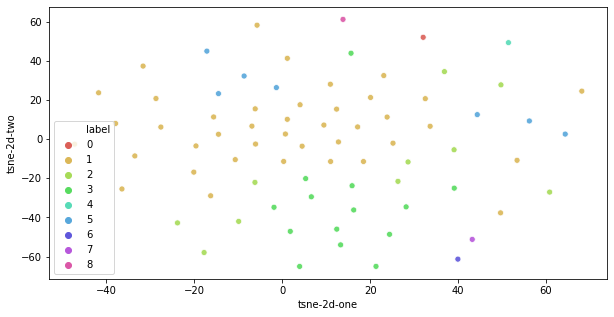

In [41]:
import seaborn as sns
plt.figure(figsize=(10,5))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 9),
    data=df_clustering,
    legend="full",
    alpha=0.9
)

### Final Clustering : Venue Main Category

In [43]:
def getLatLon(subs):
    for el in milanArea.suburbs:
        if el['name']==subs:
            return el['coords']
    
# set number of clusters
kclusters_vmc = 5
milan_cluster3 = milan_encoded_grouped_vmc.drop('Suburb', 1)
# run k-means clustering
kmeans_vmc = KMeans(n_clusters=kclusters_vmc, random_state=0).fit(milan_cluster3)
# cluster labels generated for each row in the dataframe
milan_cluster3.insert(0, 'Cluster Labels', kmeans_vmc.labels_)
milan_cluster3.insert(0, 'Suburb', milan_encoded_grouped_vmc['Suburb'])
milan_cluster3['Latitude'] = milan_cluster3.apply(lambda row: getLatLon(row.Suburb)[0] , axis=1)
milan_cluster3['Longitude'] = milan_cluster3.apply(lambda row: getLatLon(row.Suburb)[1] , axis=1)
milan_cluster3.head(10)

,Suburb,Cluster Labels,arts,food,outdoor,shop,transport,Latitude,Longitude
0,Affori,4,0.250000,0.357143,0.107143,0.214286,0.071429,45.517,9.16965
1,Baggio,2,0.058824,0.235294,0.117647,0.529412,0.058824,45.4614,9.08984
2,Barona,1,0.076923,0.410256,0.102564,0.282051,0.128205,45.4388,9.15467
3,Bicocca,1,0.017241,0.655172,0.103448,0.051724,0.172414,45.5149,9.21114
4,Boldinasco,0,0.151515,0.363636,0.151515,0.090909,0.242424,45.4926,9.13855
5,Bovisa,1,0.093750,0.453125,0.062500,0.203125,0.187500,45.5028,9.16126
6,Bovisasca,3,0.083333,0.333333,0.333333,0.166667,0.083333,45.5158,9.15378
7,Bruzzano,2,0.071429,0.178571,0.107143,0.464286,0.178571,45.5274,9.17329
8,Cagnola,2,0.087500,0.337500,0.062500,0.375000,0.137500,45.4925,9.15032
9,Calvairate,1,0.071429,0.452381,0.119048,0.238095,0.119048,45.4561,9.22062


In [44]:
# create map of Milan using latitude and longitude values
map_milan_3 = folium.Map(location=milanArea.centrion, 
                   zoom_start=12,
                   tiles = 'CartoDb dark_matter')

style_function = lambda x: {'fillColor': '#FFFFff',
                            'color': '#FFFFFF'}

folium.GeoJson(
    milanArea.geoJson,
    name='Milan geojson',
    style_function=style_function
).add_to(map_milan_3)

# set color scheme for the clusters
x = np.arange(kclusters_vmc)
ys = [i + x + (i*x)**2 for i in range(kclusters_vmc)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
for lat, lng, suburb, cluster in zip(milan_cluster3['Latitude'], milan_cluster3['Longitude'], milan_cluster3['Suburb'], milan_cluster3['Cluster Labels']):
    label = '{}, Milan, Lombardy'.format(suburb)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_milan_3)

map_milan_3

In [45]:
from sklearn.manifold import TSNE

In [46]:
X_embedded = TSNE(n_components=2).fit_transform(df_clustering_vmc)
X_embedded.shape

(76, 2)

In [47]:
df_clustering_vmc['tsne-2d-one'] = X_embedded[:,0]
df_clustering_vmc['tsne-2d-two'] = X_embedded[:,1]
df_clustering_vmc['label'] = kmeans_vmc.labels_

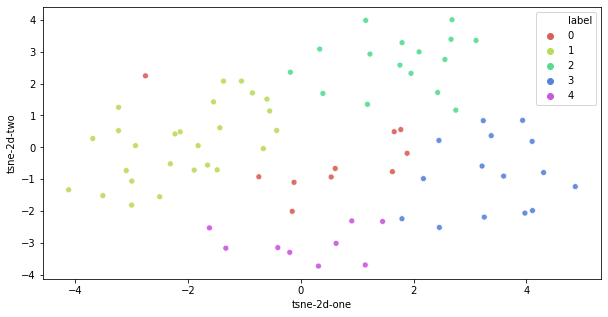

In [49]:
import seaborn as sns
plt.figure(figsize=(10,5))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 5),
    data=df_clustering_vmc,
    legend="full",
    alpha=0.9
)

#### most common venue

In [50]:
def return_most_common_venues(row, num_top_venues):
    idx = 0
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    indexes = row_categories_sorted.index.values[0:num_top_venues]
    values = row_categories_sorted.iloc[:num_top_venues]
    for idx, val in enumerate(values):
        if val == 0:
            indexes[idx] = 'N/A'
    
    return indexes

In [51]:
num_top_venues = 5
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Suburb']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
milan_top_by_sub = pd.DataFrame(columns=columns)
milan_top_by_sub['Suburb'] = milan_encoded_grouped_vmc['Suburb']

for ind in np.arange(milan_encoded_grouped_vmc.shape[0]):
    milan_top_by_sub.iloc[ind, 1:] = return_most_common_venues(milan_encoded_grouped_vmc.iloc[ind, :], num_top_venues)
milan_top_by_sub.insert(1, 'Cluster Labels', kmeans_vmc.labels_)
milan_top_by_sub.head(10)

,Suburb,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Affori,4,food,arts,shop,outdoor,transport
1,Baggio,2,shop,food,outdoor,transport,arts
2,Barona,1,food,shop,transport,outdoor,arts
3,Bicocca,1,food,transport,outdoor,shop,arts
4,Boldinasco,0,food,transport,outdoor,arts,shop
5,Bovisa,1,food,shop,transport,arts,outdoor
6,Bovisasca,3,outdoor,food,shop,transport,arts
7,Bruzzano,2,shop,transport,food,outdoor,arts
8,Cagnola,2,shop,food,transport,arts,outdoor
9,Calvairate,1,food,shop,transport,outdoor,arts


#### explore de clusters

In [52]:
milan_top_by_sub[ milan_top_by_sub['Cluster Labels'] == 0]

,Suburb,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
4,Boldinasco,0,food,transport,outdoor,arts,shop
12,Chiesa Rossa,0,transport,shop,food,arts,outdoor
14,Città Studi,0,food,transport,shop,outdoor,arts
27,Lambrate,0,food,transport,arts,shop,outdoor
31,Milan Central zone,0,food,shop,transport,arts,outdoor
33,Moncucco,0,food,transport,shop,outdoor,arts
34,Montalbino,0,food,transport,shop,outdoor,arts
37,Musocco,0,transport,food,shop,outdoor,arts
58,Quarto Oggiaro,0,transport,food,shop,outdoor,N/A
61,Rogoredo,0,transport,food,outdoor,shop,arts


In [53]:
milan_top_by_sub[ milan_top_by_sub['Cluster Labels'] == 1]

,Suburb,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Barona,1,food,shop,transport,outdoor,arts
3,Bicocca,1,food,transport,outdoor,shop,arts
5,Bovisa,1,food,shop,transport,arts,outdoor
9,Calvairate,1,food,shop,transport,outdoor,arts
10,Cantalupa,1,food,transport,shop,outdoor,N/A
11,Casoretto,1,food,shop,transport,outdoor,arts
16,Conchetta,1,food,shop,transport,outdoor,arts
17,Corvetto,1,food,shop,transport,arts,outdoor
21,Garegnano,1,food,shop,transport,outdoor,arts
26,Isola,1,food,shop,transport,outdoor,arts


In [54]:
milan_top_by_sub[ milan_top_by_sub['Cluster Labels'] == 2]

,Suburb,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Baggio,2,shop,food,outdoor,transport,arts
7,Bruzzano,2,shop,transport,food,outdoor,arts
8,Cagnola,2,shop,food,transport,arts,outdoor
22,Ghisolfa,2,shop,food,arts,outdoor,transport
28,Lampugnano,2,shop,food,transport,outdoor,arts
29,Lorenteggio,2,food,shop,outdoor,arts,transport
30,Loreto,2,food,shop,transport,outdoor,arts
38,Niguarda,2,shop,food,transport,arts,outdoor
47,Porta Ticinese,2,food,shop,transport,outdoor,arts
49,Porta Vercellina,2,shop,food,transport,outdoor,arts


In [55]:
milan_top_by_sub[ milan_top_by_sub['Cluster Labels'] == 3]

,Suburb,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
6,Bovisasca,3,outdoor,food,shop,transport,arts
15,Comasina,3,food,shop,transport,outdoor,N/A
19,Figino,3,food,outdoor,transport,shop,N/A
20,Gallaratese,3,food,shop,outdoor,transport,N/A
23,Gorla,3,food,outdoor,shop,transport,arts
24,Gratosoglio,3,shop,food,outdoor,transport,arts
36,Muggiano,3,outdoor,transport,shop,food,N/A
39,Ortica,3,shop,food,outdoor,transport,arts
54,QT8,3,food,transport,outdoor,shop,N/A
56,Quartiere Sant'Ambrogio,3,shop,outdoor,food,transport,arts


In [56]:
milan_top_by_sub[ milan_top_by_sub['Cluster Labels'] == 4]

,Suburb,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Affori,4,food,arts,shop,outdoor,transport
13,Cimiano,4,food,shop,outdoor,arts,transport
18,Crescenzago,4,food,outdoor,shop,transport,arts
25,Greco,4,food,arts,shop,transport,outdoor
53,Precotto,4,food,arts,shop,transport,outdoor
55,Quartiere Forlanini,4,food,arts,transport,shop,outdoor
60,Restocco Maroni,4,food,arts,outdoor,transport,shop
69,Taliedo,4,food,arts,shop,outdoor,transport
72,Turro,4,food,arts,outdoor,transport,shop


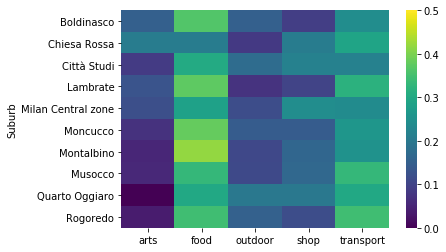

In [57]:
df = milan_cluster3[milan_cluster3['Cluster Labels']==0].drop(['Cluster Labels', 'Latitude','Longitude'], axis=1)
df.set_index('Suburb', inplace=True)
df = df.astype(float)
sns.heatmap(df, cmap='viridis',vmin=0, vmax=0.5)

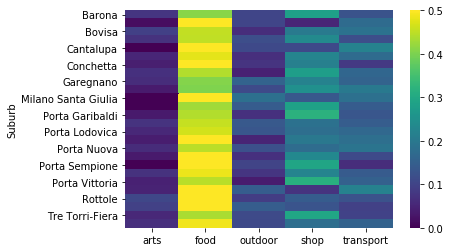

In [58]:
df = milan_cluster3[milan_cluster3['Cluster Labels']==1].drop(['Cluster Labels', 'Latitude','Longitude'], axis=1)
df.set_index('Suburb', inplace=True)
df = df.astype(float)
sns.heatmap(df, cmap='viridis',vmin=0, vmax=0.5)

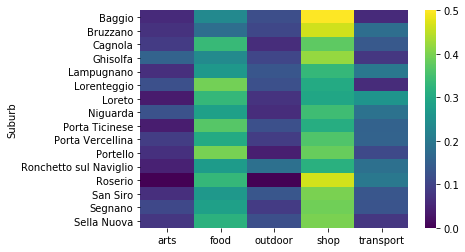

In [59]:
df = milan_cluster3[milan_cluster3['Cluster Labels']==2].drop(['Cluster Labels', 'Latitude','Longitude'], axis=1)
df.set_index('Suburb', inplace=True)
df = df.astype(float)
sns.heatmap(df, cmap='viridis',vmin=0, vmax=0.5)

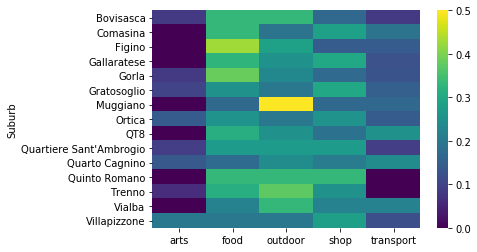

In [60]:
df = milan_cluster3[milan_cluster3['Cluster Labels']==3].drop(['Cluster Labels', 'Latitude','Longitude'], axis=1)
df.set_index('Suburb', inplace=True)
df = df.astype(float)
sns.heatmap(df, cmap='viridis',vmin=0, vmax=0.5)

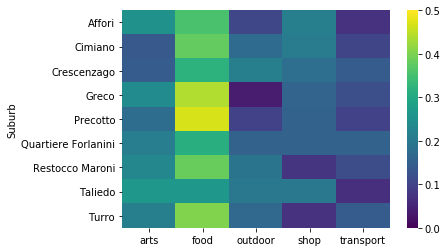

In [61]:
df = milan_cluster3[milan_cluster3['Cluster Labels']==4].drop(['Cluster Labels', 'Latitude','Longitude'], axis=1)
df.set_index('Suburb', inplace=True)
df = df.astype(float)
sns.heatmap(df, cmap='viridis',vmin=0, vmax=0.5)

Final consideration on clustering result:  
- Cluster 0: Food and Transport
- Cluster 1: Food
- Cluster 2: Shop and Food
- Cluster 3: Outdoor and Food
- Cluster 4: Food and arts

### layering heatmaps

In [62]:
listings = pd.read_csv('listings.csv')

In [63]:
homes = listings[listings['room_type']=='Entire home/apt']
homes_grouped = homes[['neighbourhood','price']].groupby('neighbourhood', as_index=False).mean()
homes_grouped.head()

,neighbourhood,price
0,ADRIANO,112.000000
1,AFFORI,84.530612
2,BAGGIO,64.972973
3,BANDE NERE,105.995633
4,BARONA,78.565217


In [64]:
milan_venues.shape

(4094, 8)

In [65]:
milan_venues[milan_venues['Venue Main Category']=='shop'].head(20)

,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Main Category
139,Milan Central zone,45.4668,9.1905,Libreria Internazionale Ulrico Hoepli,45.466456,9.192638,Bookstore,shop
140,Milan Central zone,45.4668,9.1905,Apple Piazza Liberty,45.465267,9.193701,Electronics Store,shop
141,Milan Central zone,45.4668,9.1905,Rinascente,45.464805,9.191740,Department Store,shop
142,Milan Central zone,45.4668,9.1905,Design Supermarket,45.464722,9.191704,Gift Shop,shop
143,Milan Central zone,45.4668,9.1905,Corso Vittorio Emanuele 1 & Other Stories,45.465305,9.194708,Women's Store,shop
144,Milan Central zone,45.4668,9.1905,Cartier,45.468893,9.194733,Jewelry Store,shop
145,Milan Central zone,45.4668,9.1905,Louis Vuitton,45.467176,9.196643,Boutique,shop
146,Milan Central zone,45.4668,9.1905,Intimissimi,45.464629,9.193050,Lingerie Store,shop
147,Milan Central zone,45.4668,9.1905,Armani,45.470443,9.192732,Boutique,shop
148,Milan Central zone,45.4668,9.1905,Just Cavalli,45.467087,9.196686,Boutique,shop


In [66]:
coordinates_ita = [[venue[4], venue[5]] for venue in milan_venues[milan_venues['Venue Category']=='Sushi Restaurant'].values]
print(len(coordinates_ita))
coordinates_art = [[venue[4], venue[5]] for venue in milan_venues[milan_venues['Venue Category']=='Theater'].values]
print(len(coordinates_art))
coordinates_shop = [[venue[4], venue[5]] for venue in milan_venues[milan_venues['Venue Category']=='Clothing Store'].values]
print(len(coordinates_shop))
joint_coords = coordinates_ita + coordinates_art + coordinates_shop
print(len(joint_coords))

47
35
61
143


In [69]:
# create map of Milan using latitude and longitude values
milan_heat = folium.Map(location=milanArea.centrion, 
                       zoom_start=13,
                       tiles = 'CartoDb dark_matter')

style_function = lambda x: {'fillColor': '#FFFFff',
                            'color': '#FFFFff'}

folium.GeoJson(
    milanArea.geoJson,
    name='Milan geojson',
    style_function=style_function
).add_to(milan_heat)

folium.Choropleth(
    geo_data='neighbourhoods.geoJson',
    name='choropleth',
    data=homes_grouped,
    columns=['neighbourhood', 'price'],
    key_on='feature.properties.neighbourhood',
    fill_color='BuPu',
    fill_opacity=0.6,
    line_opacity=0.2,
    legend_name='Medium price/night airbnb apartment'
).add_to(milan_heat)


folium.CircleMarker(
        milanArea.centrion,
        radius=5,
        popup='Milan, Lombardy, Italy',
        color='white',
        fill=True,
        fill_color='#F4F6F7',
        fill_opacity=0.7,
        parse_html=False).add_to(milan_heat)
  
for coords in coordinates_ita:
    folium.CircleMarker(
        coords,
        radius=2,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.1,
        parse_html=False).add_to(milan_heat)
for coords in coordinates_art:
    folium.CircleMarker(
        coords,
        radius=2,
        color='orange',
        fill=True,
        fill_color='orange',
        fill_opacity=0.1,
        parse_html=False).add_to(milan_heat)
for coords in coordinates_shop:
    folium.CircleMarker(
        coords,
        radius=2,
        color='yellow',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.1,
        parse_html=False).add_to(milan_heat)


plugins.HeatMap(joint_coords, name='heat', radius=20).add_to(milan_heat)

# add markers to map
for lat, lng, suburb, cluster in zip(milan_cluster3['Latitude'], milan_cluster3['Longitude'], milan_cluster3['Suburb'], milan_cluster3['Cluster Labels']):
    label = '{}, Milan, Lombardy'.format(suburb)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='white',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1,
        parse_html=False).add_to(milan_heat)
    

folium.LayerControl().add_to(milan_heat)

milan_heat

references:  
- https://nominatim.openstreetmap.org/details.php?osmtype=R&osmid=44915&class=boundary
- https://nominatim.org/release-docs/develop/api/Details/
- https://python-visualization.github.io/folium/quickstart.html
- https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
- https://alysivji.github.io/getting-started-with-folium.html
- https://developer.foursquare.com/docs/build-with-foursquare/categories
- https://medium.com/@jyotiyadav99111/selecting-optimal-number-of-clusters-in-kmeans-algorithm-silhouette-score-c0d9ebb11308
- http://insideairbnb.com/get-the-data.html